# Histogram manipulations and fitting

# Histogram libraries

Mainstream Python has libraries for filling histograms.

## NumPy

NumPy, for instance, has an [np.histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) function.

In [1]:
import skhep_testdata, uproot

tree = uproot.open(skhep_testdata.data_path("uproot-Zmumu.root"))["events"]

import numpy as np

np.histogram(tree["M"].array())

<Array [[172, 89, 29, 69, 277, ..., 24, 0, 2, 2], ...] type='2 * var * float64'>

Because of NumPy's prominence, this 2-tuple of arrays (bin contents and edges) is a widely recognized histogram format, though it lacks many of the features high-energy physicists expect (under/overflow, axis labels, uncertainties, etc.).

## Matplotlib

Matplotlib also has a [plt.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) function.

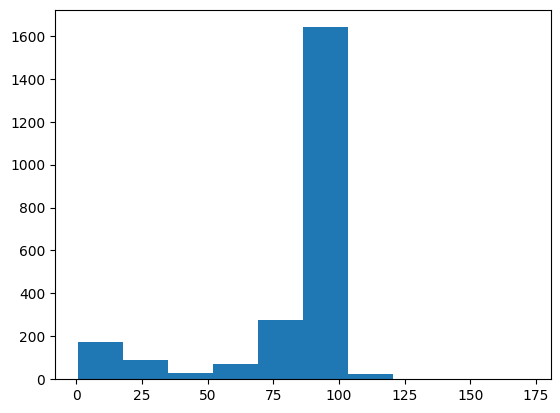

In [2]:
import matplotlib.pyplot as plt

plt.hist(tree["M"].array());

In addition to the same bin contents and edges as NumPy, Matplotlib includes a plottable graphic.

## Boost-histogram and hist

The main feature that these functions lack (without some effort) is refillability. High-energy physicists usually want to fill histograms with more data than can fit in memory, which means setting bin intervals on an empty container and filling it in batches (sequentially or in parallel).

Boost-histogram is a library designed for that purpose. It is intended as an infrastructure component. You can explore its "low-level" functionality upon importing it:

In [3]:
import boost_histogram as bh

A more user-friendly layer (with plotting, for instance) is provided by a library called "hist."

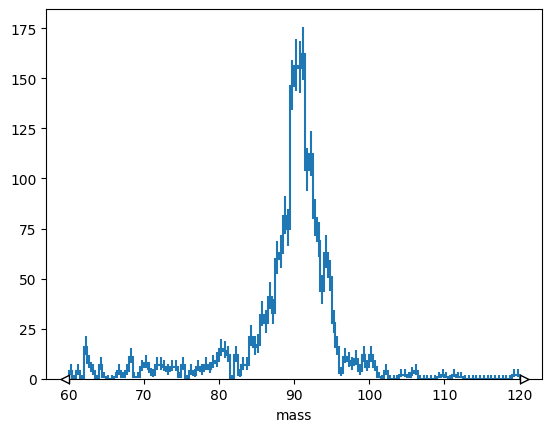

In [4]:
import hist

h = hist.Hist(hist.axis.Regular(120, 60, 120, name="mass"))

h.fill(tree["M"].array())

h.plot();

## Universal Histogram Indexing (UHI)

There is an attempt within Scikit-HEP to standardize what array-like slices mean for a histogram. ([See documentation](https://uhi.readthedocs.io/en/latest/indexing.html).)

Naturally, integer slices should select a range of bins,

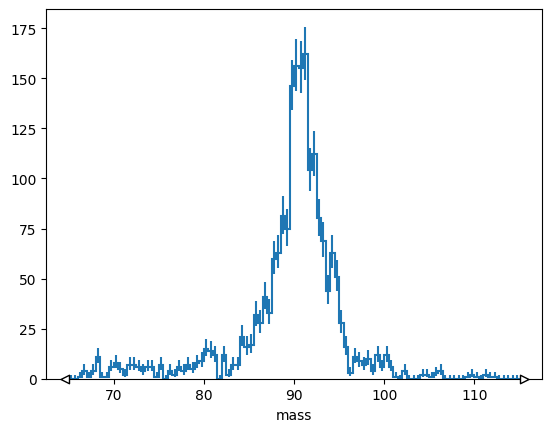

In [5]:
h[10:110].plot();

but often you want to select bins by coordinate value

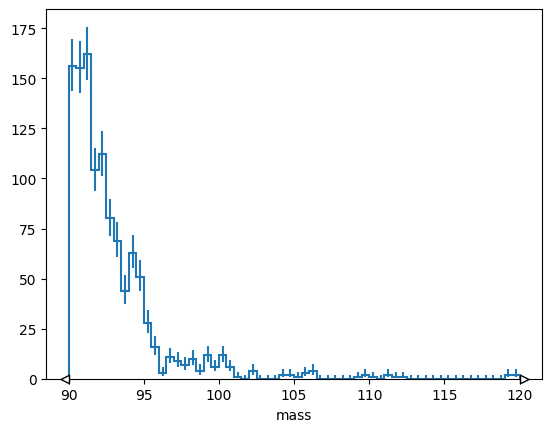

In [6]:
# Explicit version
# h[hist.loc(90) :].plot();

# Short version
h[90j:].plot();

or rebin by a factor,

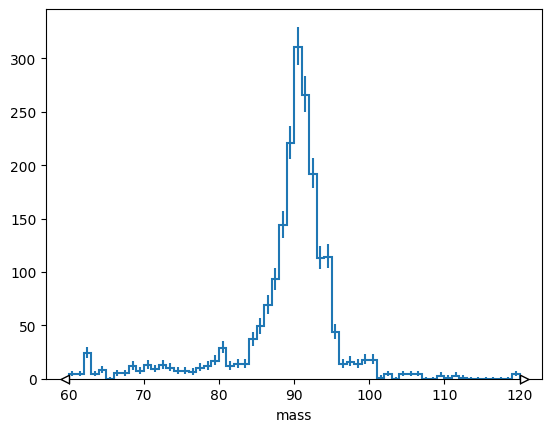

In [7]:
# Explicit version
# h[:: hist.rebin(2)].plot();

# Short version
h[::2j].plot();

or sum over a range.

In [10]:
# Explicit version
print(h[hist.loc(80) : hist.loc(100) : sum])

# Short version
h[90j:100j:sum]

1784.0


1102.0

Things get more interesting when a histogram has multiple dimensions.

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x725b765badd0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

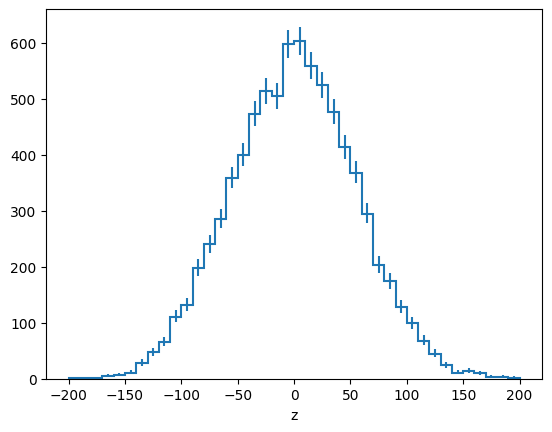

In [14]:
import uproot
import hist
import awkward as ak

picodst = uproot.open(
    "https://pivarski-princeton.s3.amazonaws.com/pythia_ppZee_run17emb.picoDst.root:PicoDst"
)

vertexhist = hist.Hist(
    hist.axis.Regular(600, -1, 1, label="x"),
    hist.axis.Regular(600, -1, 1, label="y"),
    hist.axis.Regular(40, -200, 200, label="z"),
)

vertex_data = picodst.arrays(filter_name="*mPrimaryVertex[XYZ]")

vertexhist.fill(
    ak.flatten(vertex_data["Event.mPrimaryVertexX"]),
    ak.flatten(vertex_data["Event.mPrimaryVertexY"]),
    ak.flatten(vertex_data["Event.mPrimaryVertexZ"]),
)

#vertexhist[:, :, sum].plot2d_full()
#vertexhist[-0.25j:0.25j, -0.25j:0.25j, sum].plot2d_full()
vertexhist[sum, sum, :].plot()
#vertexhist[-0.25j:0.25j:sum, -0.25j:0.25j:sum, :].plot();

A histogram object can have more dimensions than you can reasonably visualize—you can slice, rebin, and project it into something visual later.

# Fitting histograms

By directly writing a loss function in Minuit:

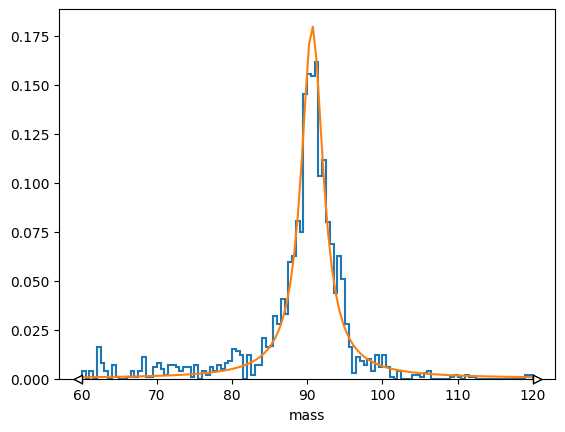

In [16]:
import numpy as np
import iminuit.cost

norm = len(h.axes[0].widths) / (h.axes[0].edges[-1] - h.axes[0].edges[0]) / h.sum()


def f(x, background, mu, gamma):
    return (
        background
        + (1 - background) * gamma**2 / ((x - mu) ** 2 + gamma**2) / np.pi / gamma
    )


loss = iminuit.cost.LeastSquares(
    h.axes[0].centers, h.values() * norm, np.sqrt(h.variances()) * norm, f
)
loss.mask = h.variances() > 0

minimizer = iminuit.Minuit(loss, background=0, mu=91, gamma=4)

minimizer.migrad()
minimizer.hesse()

(h * norm).plot()
plt.plot(loss.x, f(loss.x, *minimizer.values))

Or through zfit, a Pythonic RooFit-like fitter:

/home/vscode/.local/lib/python3.10/site-packages/zfit/__init__.py:68: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale


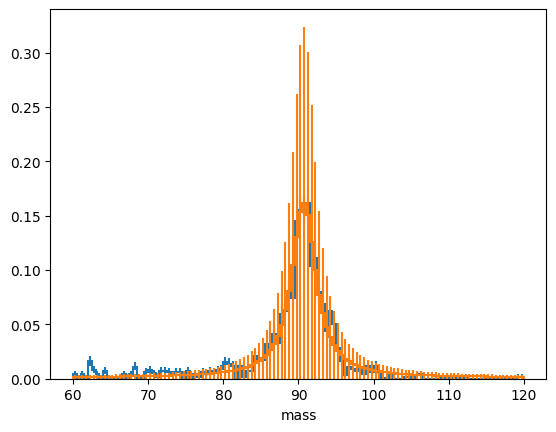

In [17]:
import zfit

binned_data = zfit.data.BinnedData.from_hist(h)

binning = zfit.binned.RegularBinning(120, 60, 120, name="mass")
space = zfit.Space("mass", binning=binning)

background = zfit.Parameter("background", 0)
mu = zfit.Parameter("mu", 91)
gamma = zfit.Parameter("gamma", 4)
unbinned_model = zfit.pdf.SumPDF(
    [zfit.pdf.Uniform(60, 120, space), zfit.pdf.Cauchy(mu, gamma, space)], [background]
)

model = zfit.pdf.BinnedFromUnbinnedPDF(unbinned_model, space)
loss = zfit.loss.BinnedNLL(model, binned_data)

minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(loss)

binned_data.to_hist().plot(density=1)
model.to_hist().plot(density=1);